# Background

Links:
- [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)
- [BayesSearchCV Docs Example](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Integer
from time import time

plt.style.use("../style.mplstyle")
%matplotlib inline

In [2]:
data = pd.read_csv("../data/cardio.csv", sep=";", index_col=0)
n_samples = 20000
X, y = data.iloc[:n_samples, :-1].values, data.iloc[:n_samples, -1].values
print(f"Number of records         : {X.shape[0]}")
print(f"Number of features        : {X.shape[1]}")
print(f"Count of positive outcomes: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
data.sample(10)

Number of records         : 20000
Number of features        : 11
Count of positive outcomes: 9861 (49.3%)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
29271,19749,1,154,66.0,140,90,1,1,0,0,1,1
97919,15949,2,166,70.0,140,80,1,1,0,0,0,0
60439,23107,1,167,71.0,120,60,1,1,0,0,1,1
28160,21741,2,163,82.0,140,90,1,1,0,1,1,0
42748,14838,1,167,76.0,110,80,2,1,0,0,0,0
71206,20679,1,160,60.0,120,80,3,3,0,0,1,1
81670,17313,2,178,80.0,120,80,1,1,0,0,1,0
29130,22077,1,167,61.0,110,70,1,1,0,0,1,0
17922,20155,2,165,85.0,140,90,3,1,0,0,1,1


In [3]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
model = LGBMClassifier(random_state=42)

In [4]:
lgb_params = {
    "num_leaves": Integer(7, 127),
    "max_depth": Integer(10, 300),
    "learning_rate": Real(1e-4, 1e+2, 'log-uniform'),
    "min_child_samples": Integer(2, 100),
    "reg_alpha": (0, 1, 'log-uniform'),
    "reg_lambda": (0, 1, 'log-uniform'),
}

## BayesSearchCV

In [5]:
start = time()

opt = BayesSearchCV(
    model,
    lgb_params,
    n_iter=512,
    cv=cv,
    n_jobs=1,
    random_state=42,
    scoring="roc_auc",
)
print(f"Number of iterations: {opt.total_iterations}")  # n_iter * 6

best_score, iteration = 0, 0
# callback handler
def on_step(optim_result):
    global best_score
    global iteration
    iteration += 1
    score = opt.best_score_
    if score > best_score:
        best_score = score
        print(f"\nBest score (iteration): {best_score:.4f} ({iteration})")
    elif iteration % 10 == 0:
        print(
            f"Iteration {iteration}, runtime {(time() - start) / 60:.1f} minutes...",
            end="\r",
        )


opt.fit(X_train, y_train, callback=on_step)
end = time()
print(f"\nRun time     : {(end - start) / 60:.1f} minutes")
print(f"Best score     : {opt.best_score_:.4f}")
print(f"Test score     : {opt.score(X_test, y_test):.4f}")
print("Best parameters:")
for item in opt.best_params_.items():
    print(f"\t{item}")

Number of iterations: 3072

Best score (iteration): 0.7967 (1)
Iteration 10, runtime 0.6 minutes...
Best score (iteration): 0.7988 (18)
Iteration 20, runtime 1.7 minutes...
Best score (iteration): 0.7992 (22)
Iteration 30, runtime 2.5 minutes...
Best score (iteration): 0.7993 (35)
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[Lig

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

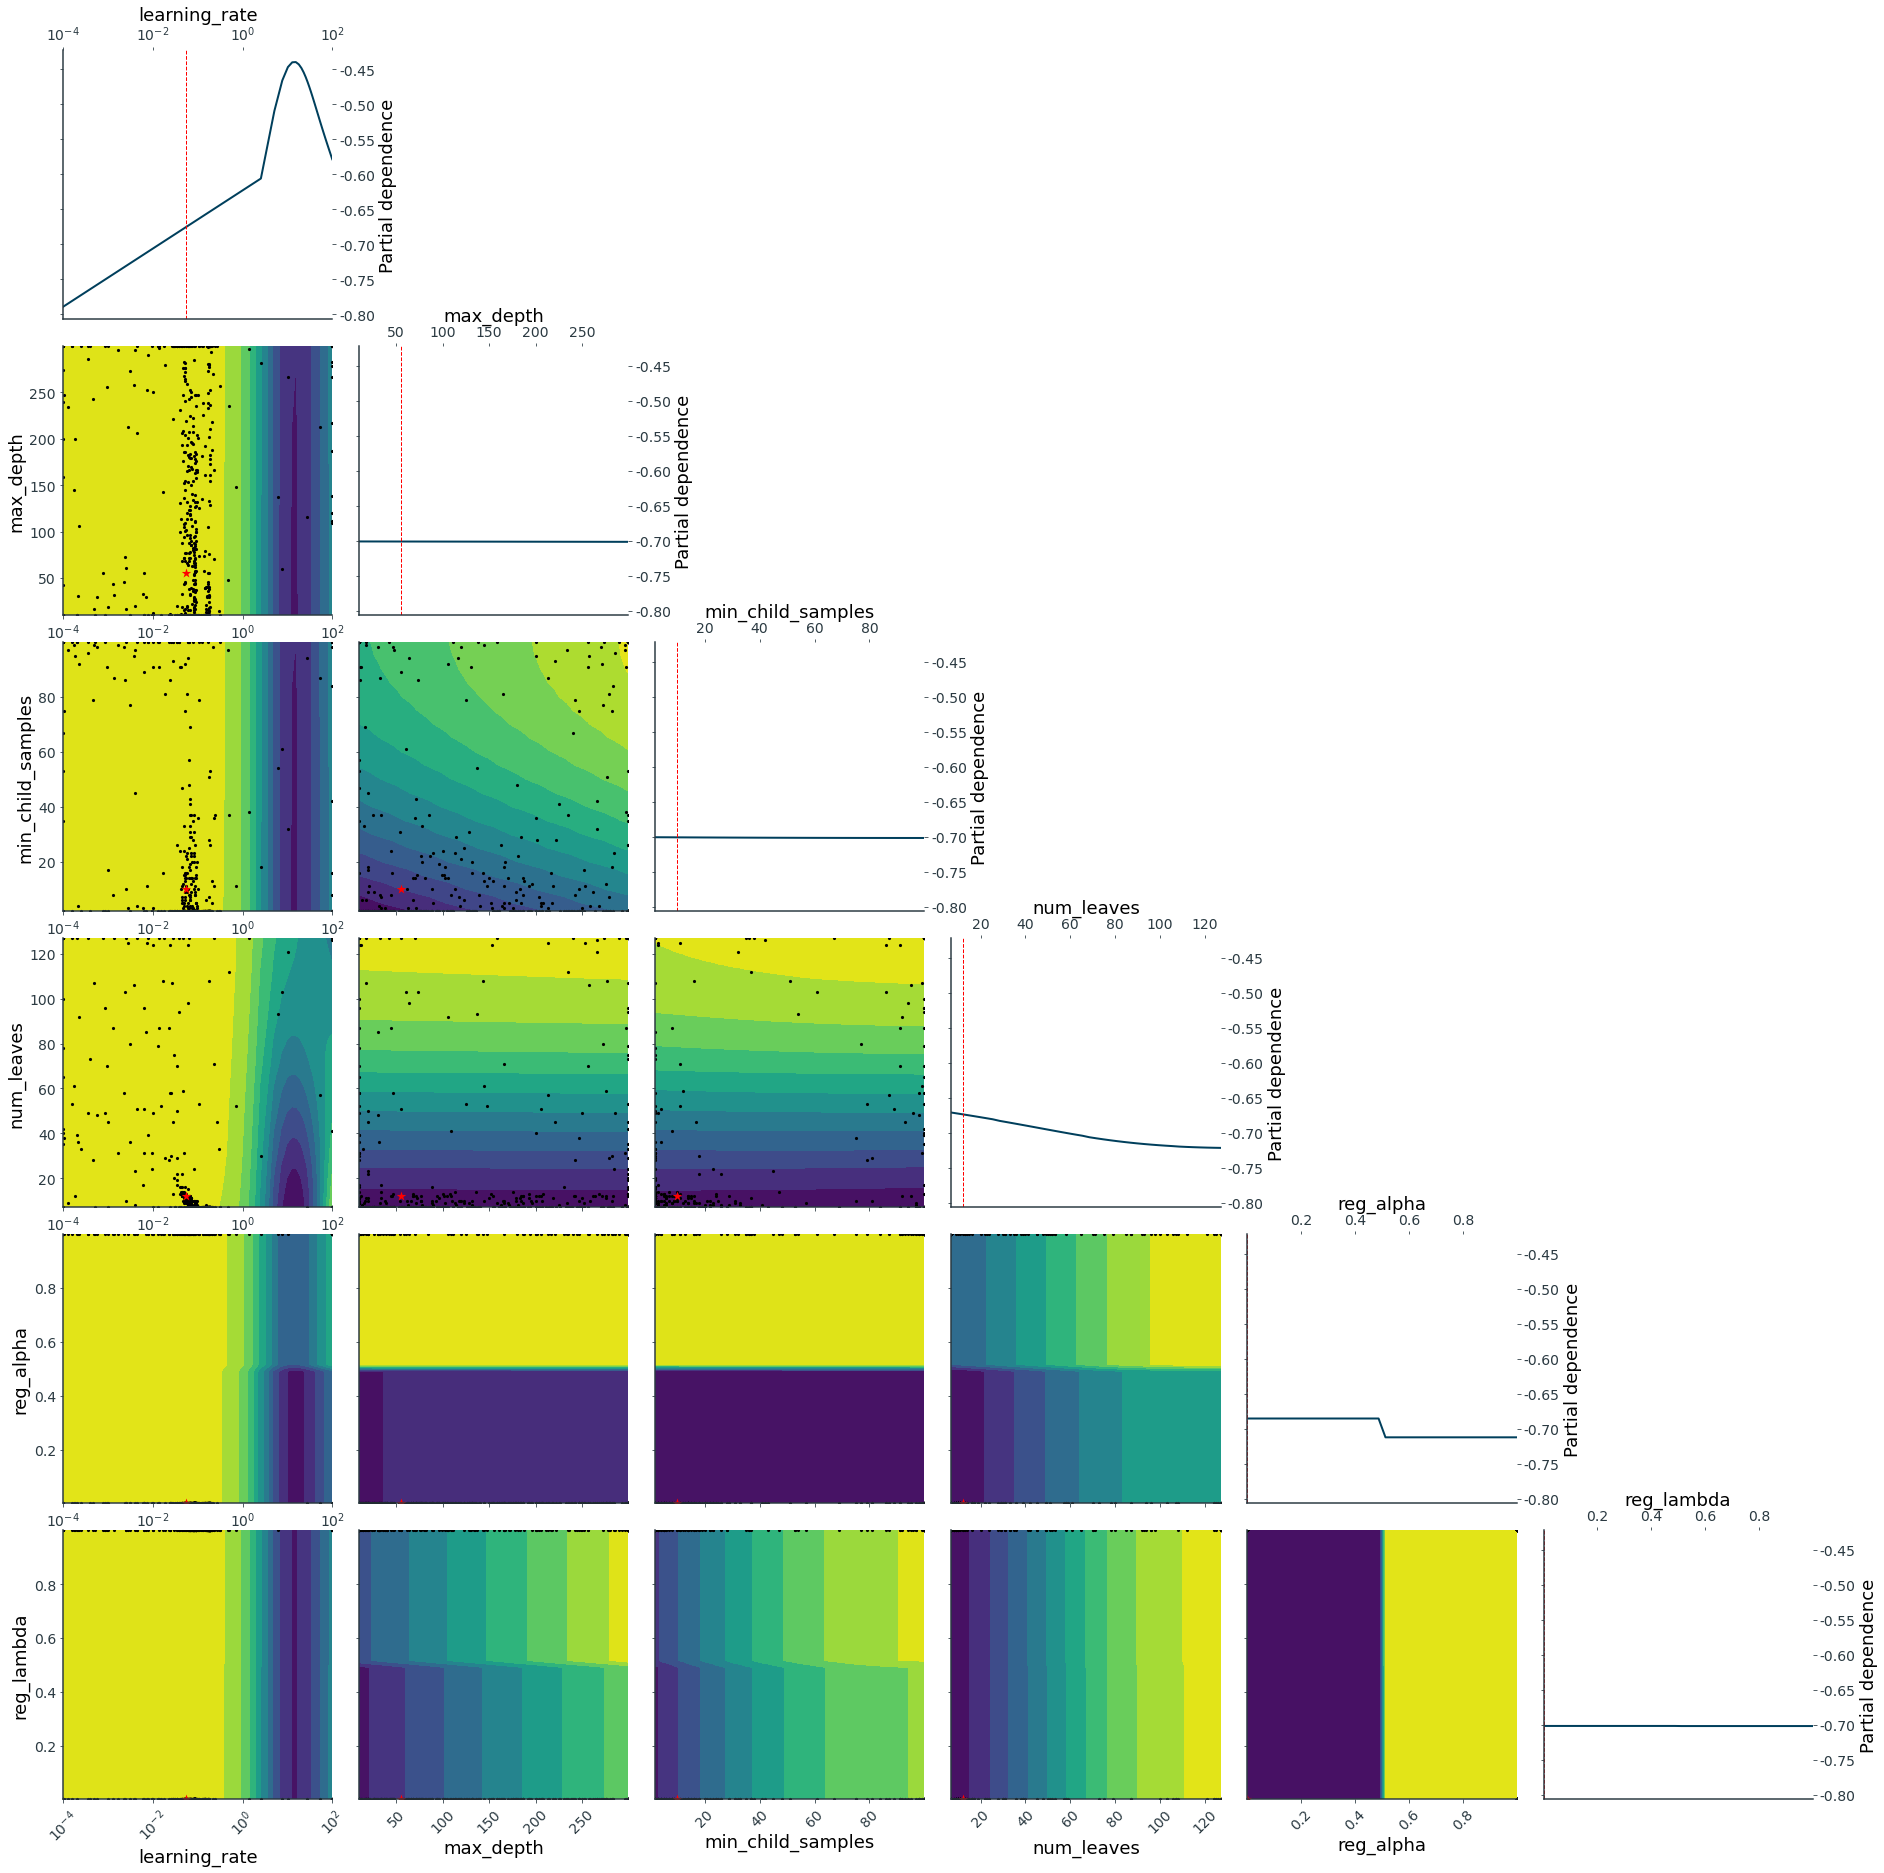

In [6]:
_ = plot_objective(
    opt.optimizer_results_[0],
    dimensions=[
        "learning_rate",
        "max_depth",
        "min_child_samples",
        "num_leaves",
        "reg_alpha",
        "reg_lambda",
    ],
    n_minimum_search=int(1e8),
    size=4.5,
)

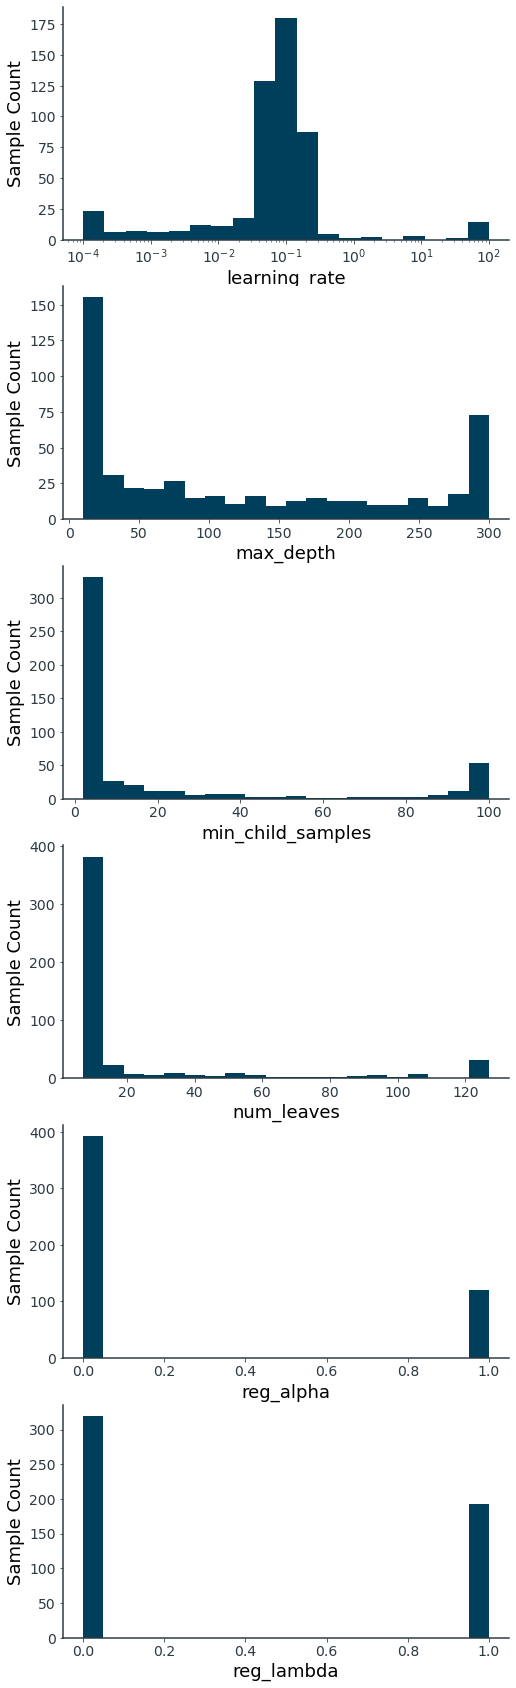

In [7]:
fig, ax = plt.subplots(6, 1, figsize=(8, 30))
for i in range(6):
    plot_histogram(opt.optimizer_results_[0], i, ax=ax[i])